# CNN Model Template

This notebook is a template for building a CNN model.

## Imports and inital setup

In [1]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 42
NUM_EPOCHS = 1

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx"
BALANCE_LABEL="dx"
IMAGE_SIZE = (64, 64)

### Loading (augmented) metadata as test, train, validation from files

In [4]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
10853,HAM_0006770,aug_m7XNUiISIC_0028309.jpg,bkl,consensus,70.0,female,back,vidir_modern,not_skin_cancer,./../data/jpgs/aug_m7XNUiISIC_0028309.jpg
6986,HAM_0002343,aug_SWyTMHISIC_0028158.jpg,akiec,histo,70.0,female,back,rosendahl,skin_cancer,./../data/jpgs/aug_SWyTMHISIC_0028158.jpg
10103,HAM_0001781,ISIC_0029823.jpg,bkl,consensus,30.0,female,back,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0029823.jpg
5586,HAM_0002817,aug_IOCy1YISIC_0030255.jpg,mel,histo,70.0,female,upper extremity,rosendahl,skin_cancer,./../data/jpgs/aug_IOCy1YISIC_0030255.jpg
11874,HAM_0001721,aug_Yc7KG1ISIC_0031181.jpg,bkl,histo,40.0,male,face,rosendahl,not_skin_cancer,./../data/jpgs/aug_Yc7KG1ISIC_0031181.jpg
10531,HAM_0000728,ISIC_0025286.jpg,bkl,histo,50.0,male,lower extremity,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0025286.jpg
1098,HAM_0005015,ISIC_0026355.jpg,nv,follow_up,60.0,male,trunk,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0026355.jpg
8371,HAM_0004549,aug_nSCkNIISIC_0031201.jpg,vasc,consensus,45.0,male,trunk,vidir_molemax,not_skin_cancer,./../data/jpgs/aug_nSCkNIISIC_0031201.jpg
11019,HAM_0000581,aug_LfkKUlISIC_0034115.jpg,bkl,histo,40.0,female,chest,vidir_modern,not_skin_cancer,./../data/jpgs/aug_LfkKUlISIC_0034115.jpg
12013,HAM_0005112,ISIC_0024386.jpg,df,consensus,40.0,female,lower extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0024386.jpg


## Setting up the image data generator for training and validation

In [2]:
def custom_preprocessing(np_image, image_size):
    np_image = ih.center_crop(np_image, image_size)
    np_image = ih.resize_image(np_image, image_size)
    return np_image

In [5]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE),
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE),
    rescale=1.0 / 255.0 #see above
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 2003 validated image filenames belonging to 7 classes.
Found 14006 validated image filenames belonging to 7 classes.


# Adding an neural network model to test the data

## Simple Model Architecture

Source: https://www.tensorflow.org/tutorials/images/cnn (with minor changes)

In [4]:
# Define super basic neural network architecture
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

    # Convolutional block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # Flattening the output of the convolutional layers
    tf.keras.layers.Flatten(),

    # Dense (fully connected) layers
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

## Model Training

In [5]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=None,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=None,                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

44/44 [==============================] - 22s 506ms/step - loss: 0.4361 - accuracy: 0.1568 - val_loss: 0.4312 - val_accuracy: 0.0749


## Plotting accuracy and loss of train and validation set

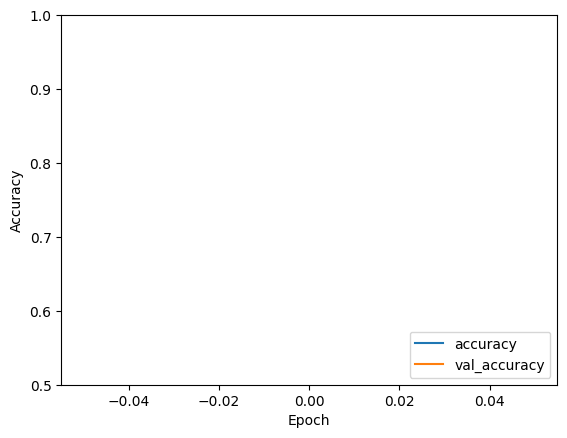

In [6]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

In [7]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

63/63 - 2s - loss: 65.1376 - accuracy: 0.0704 - 2s/epoch - 36ms/step


## Saving the model

In [8]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
